# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [1]:
# Import the Obspy modules that will be useful to download seismic data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [2]:
# answer below
Tstart = UTCDateTime(2015,1,1)
Tend = UTCDateTime(2015,1,31) # Needed fewer days to run it faster
fdsn_client = fdsn.Client('IRIS') # client to query the IRIS DMC server

Z = fdsn_client.get_waveforms(network='XH', station='DR01', location='--', 
                              channel='LHN', starttime=Tstart, endtime=Tend, 
                              attach_response=True)

In [3]:
Z.merge().detrend(type='linear')
Z[0].taper(max_percentage=0.05)
Z[0].remove_response()

XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-01-30T23:59:59.000000Z | 1.0 Hz, 2592000 samples

In [4]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

30


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

In [5]:
# answer below
import scipy.signal as signal
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

fs = Z[0].stats.sampling_rate

sos_lp = signal.butter(2,0.01, btype='lowpass', fs=fs, output='sos')
z_lp = signal.sosfilt(sos_lp, Z[0])

sos_bp = signal.butter(2, [0.01, 0.1], 'bandpass', fs=fs, output='sos')
z_bp = signal.sosfilt(sos_bp, Z[0])

sos_bp = signal.butter(2, [0.01, 0.1], 'bandpass', fs=fs, output='sos')
z_bp = signal.sosfilt(sos_bp, Z[0])

**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

In [6]:
# import FFT modules
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

# answer below
Nfft = next_fast_len(int(Z[0].data.shape[0])) 
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat = fft(Z[0].data,n=Nfft)

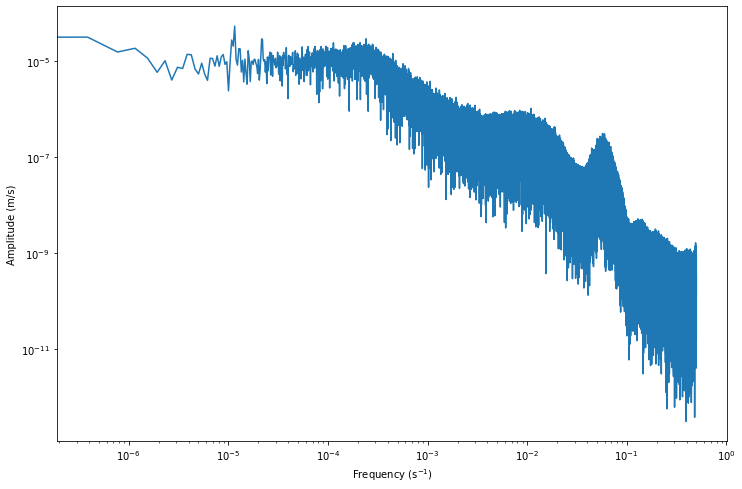

In [7]:
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
ax.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Frequency (s$^{-1}$)')
plt.ylabel('Amplitude (m/s)')
plt.show()

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

They work just as we expected! Lowpass filter "passes" "low" frequency signals through, highpass filter passes high frequency signals, and the bandpass passes signals within a specified band.

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

**e. Sanity check (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. The key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [8]:
# answer below
volcdata = pd.read_csv("TEC/ioncorr_samo_015_2022_tonga.csv")
print(volcdata.keys)
end = volcdata.time[0] + 7200
first2hrs = volcdata[volcdata["time"]<end]

<bound method NDFrame.keys of        Unnamed: 0   GPS_seconds  satellite_number  variometric_derived_TEC  \
0               0  1.326293e+09                 1                 0.012495   
1               1  1.326293e+09                 1                 0.040731   
2               2  1.326293e+09                 1                 0.053964   
3               3  1.326293e+09                 1                 0.077087   
4               4  1.326293e+09                 1                 0.076847   
...           ...           ...               ...                      ...   
14384       14384  1.326284e+09                32                 0.095299   
14385       14385  1.326284e+09                32                 0.076074   
14386       14386  1.326284e+09                32                 0.096131   
14387       14387  1.326284e+09                32                 0.093255   
14388       14388  1.326284e+09                32                 0.053626   

       variometric_derived_TEC_fi

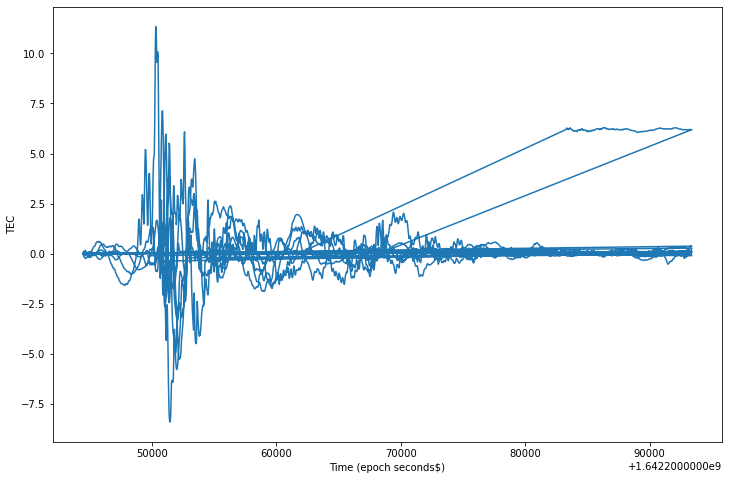

In [9]:
fig=plt.figure(figsize=(12,8))
ax=fig.gca()
ax.plot(first2hrs["time"],first2hrs["variometric_derived_TEC"])
plt.xlabel('Time (epoch seconds$)')
plt.ylabel('TEC')
plt.show()

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [10]:
# answer below
stat_name = "TEC/ioncorr_samo_015_2022_tonga.csv".split("ioncorr_")[1].split("_")[0]
print(stat_name)

samo


## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each satellite observations.

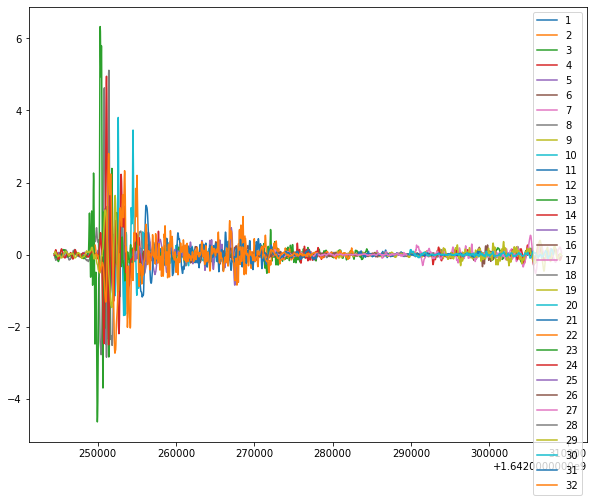

In [11]:
# answer below
volcdata["time_dt64s"] = pd.Series(volcdata["time"], dtype="datetime64[s]")
volcdata

plt.figure(figsize=(10, 8))
for i in range(32):
    sat_sub = volcdata[volcdata["satellite_number"]==(i+1)]
    plt.plot(sat_sub["time"], sat_sub["variometric_derived_TEC_filtered"], label=i+1)
plt.legend()
plt.show()

volcdata.value_counts("satellite_number")

single_sat = volcdata[volcdata.satellite_number==32]

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. Select the time series of interest and plot the time series. What can you tell about the time-frequency characteristic of these disturbances?

Calculate the sampling frequency by taking the time difference between two samples.

In [12]:
#answer below
samp_freq = single_sat.time.values[1]-single_sat.time.values[0]
print(samp_freq)

30.0


Perform the wavelet transform. You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

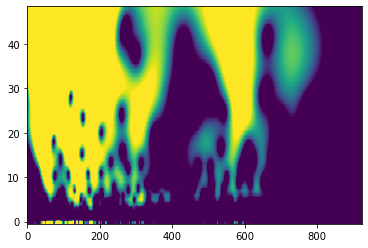

In [13]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)

# answer below
wavetrans = signal.cwt(data=single_sat["variometric_derived_TEC_filtered"], 
                       wavelet=signal.morlet2, widths=w)
plt.imshow(np.log10(np.abs(wavetrans)), cmap='viridis', aspect='auto',
           vmax=0, vmin=-0.5,origin='lower')

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

Immediately after the eruption, there's a huge number of wave periods with everything from super-short 10s up to 50+. Later there's a second set of high-period (long wavelength) signals (the tsunami disturbance?).

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc``, ``NCM_SpatialGrid.nc``, and ``NCM_AuxData.nc``.

We first download the data from our Dropbox folder


In [14]:
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1") #"./data/NCM_GeologicFrameworkGrids.nc"
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1") #"./data/NCM_AuxData.nc"



In the following we will prepare our data. Read the DataSets using the python NetCDF4 library.

In [15]:
# ansert below
import netCDF4 as nc
geogrid = nc.Dataset("NCM_GeologicFrameworkGrids.nc")
spatgrid = nc.Dataset('NCM_SpatialGrid.nc')
extradata = nc.Dataset('NCM_AuxData.nc')

**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``, which are data sets from the NC files. Use the matplotlib function``contourf``, and the variables for lat long ``x`` and ``y`` . You can use the argument ``levels`` to the contourf funxtion to split the color map into discrete contour levels, and the transparency argument ``alpha`` to be less than 1.

In [16]:
# answer below
x_coords = spatgrid["x"][0:4901, 0:3201]
y_coords = spatgrid["y"][0:4901, 0:3201]
elev = geogrid['Surface Elevation'][0:4901, 0:3201]
wtable = extradata['Water Table Depth'][0:4901, 0:3201]

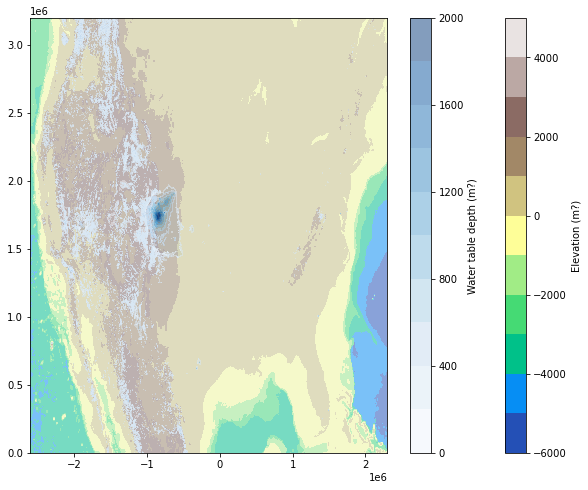

In [23]:
# plot below
plt.figure(figsize=(10, 8))

elev_plot = plt.contourf(x_coords, y_coords, elev, levels=10, cmap="terrain")
wtab_plot = plt.contourf(x_coords, y_coords, wtable, levels=10, cmap="Blues", alpha=0.5)
elev_cbar = plt.colorbar(elev_plot)
wtab_cbar = plt.colorbar(wtab_plot)
elev_cbar.set_label('Elevation (m?)')
wtab_cbar.set_label('Water table depth (m?)')

plt.show()

**b. Perform and plot the 2D Fourier transforms (4 points)**

Text(0.5, 1.0, 'Water table')

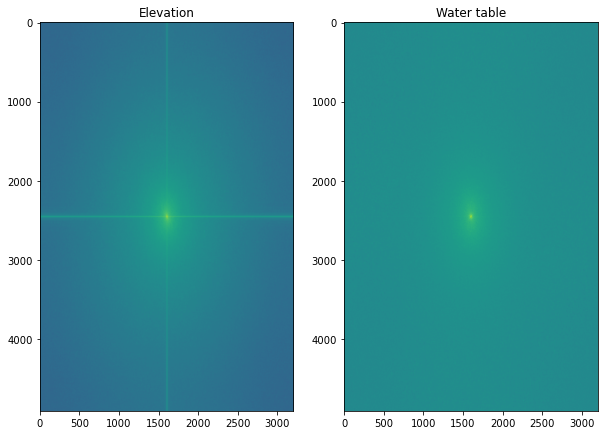

In [25]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm

freqVec = fftfreq(len(elev))[:len(elev)//2]

fig, ax = plt.subplots(1,2, figsize=(10,8))
Zelev = fft2(elev)
elev_ax = ax[0].imshow(fftshift(np.log10(np.abs(Zelev)/Zelev.size)))
ax[0].set_title('Elevation')
# cbar = fig.colorbar(elev_ax)

Zwtab = fft2(wtable)
wtab_ax = ax[1].imshow(fftshift(np.log10(np.abs(Zwtab)/Zwtab.size)))
ax[1].set_title('Water table')
# cbar = fig.colorbar(wtab_ax)

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

The elevation transform has a really interesting "star" pattern where the plot is brightest in the center which I think corresponds to long wavelengths, with long tails on the horizontal and vertical axes - I don't know what these correspond to, and they only show up in the elevation axis unlike the water table which really only has signal in the very center.

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [19]:
# solution
import scipy.signal as signal
sos_lp = signal.butter(2,0.01, btype='lp', output='sos')
Zelev_filt = signal.sosfiltfilt(sos_lp, Zelev)
Zwtab_filt = signal.sosfiltfilt(sos_lp, Zwtab)


Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [20]:
# Sort the Fourier coefficients
from scipy.fftpack import ifft2
Zelev_sorted = np.sort(np.abs(np.abs(Zelev_filt).reshape(-1)))
Zwtab_sorted = np.sort(np.abs(np.abs(Zwtab_filt).reshape(-1)))

# 1% case
thresh = Zwtab_sorted[int(np.floor(len(Zwtab_sorted)*(0.99)))]
ind = np.abs(Zwtab)>thresh
crap = Zwtab * ind 
crap_trans_99 = ifft2(crap).real

# 10% case
thresh = Zwtab_sorted[int(np.floor(len(Zwtab_sorted)*(0.9)))]
ind = np.abs(Zwtab)>thresh
crap = Zwtab * ind 
crap_trans_90 = ifft2(crap).real

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

(-2600000.0, 2300000.0, 0.0, 3200000.0)

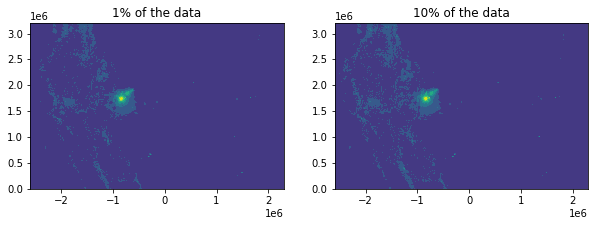

In [21]:
#answer below
from IPython import display
import time

fig,ax=plt.subplots(1,2,figsize=(10,8),sharex=True)
ax[0].contourf(x_coords, y_coords, crap_trans_99)
ax[0].set_title('1% of the data')
ax[0].axis('scaled')
ax[1].contourf(x_coords, y_coords, crap_trans_90)
ax[1].set_title('10% of the data')
ax[1].axis('scaled')

Now we will compare the original 2D data set with the Fourier compressed data


Text(0.5, 1.0, 'Original data')

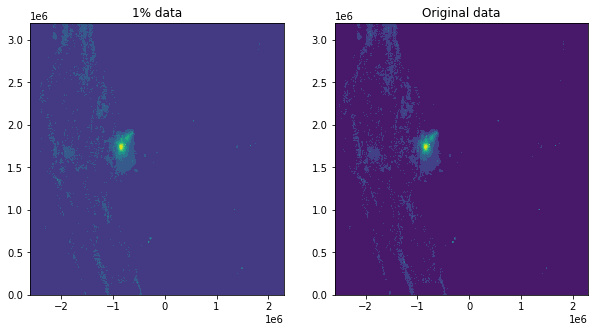

In [26]:
# answer below
fig,ax=plt.subplots(1,2,figsize=(10,5), sharex=True)
ax[0].contourf(x_coords, y_coords, crap_trans_99)
ax[0].set_title('1% data')
ax[1].contourf(x_coords, y_coords, wtable)
ax[1].set_title('Original data')